# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
def initBump(data_args, dataShape, d_shift=1e6,D=0.5*1e6):

    eta0  = np.zeros(dataShape, dtype=np.float32, order='C')
    hu0   = np.zeros(dataShape, dtype=np.float32, order='C')
    hv0   = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = data_args["dx"]*(data_args["nx"]+4)*0.5
    y_center = data_args["dy"]*(data_args["ny"]+4)*0.5

    scale = 1e9
    for j in range(data_args["ny"] + 4):
        for i in range(data_args["nx"] + 4):
            x = data_args["dx"]*i - x_center
            y = data_args["dy"]*j - y_center

            d = np.sqrt(x**2 + y**2)
            
            eta0[j, i] += 0.1*(1.0+np.tanh(-(d-d_shift)/D))

    return eta0, hu0, hv0

In [5]:
def initLevel(l):
    data_args = {}
    data_args["nx"] = 2**l
    data_args["ny"] = 2**(l+1) 
    dataShape = (data_args["ny"] + 4, data_args["nx"] + 4)

    data_args["dx"] = 2**(19-l)*100
    data_args["dy"] = 2**(19-l)*100

    data_args["dt"] = 0.0
    data_args["g"] = 9.81
    data_args["f"] = 1.2e-4
    data_args["r"] = 0.0
    # data_args["boundary_conditions"] = Common.BoundaryConditions(1,1,1,1)

    data_args["eta0"], data_args["hu0"], data_args["hv0"] = initBump(data_args, dataShape)
    
    H0 = 1000.0
    data_args["H"] = np.ma.array(np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0, mask=False)

    return data_args

In [6]:
def wind_bump(ny, nx, sig = None):
    dataShape = (ny, nx )
    w = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = 0.5*nx
    y_center = 0.5*ny

    if sig is None:
        sig = nx**2/10

    for j in range(ny):
        for i in range(nx):
            x = i - x_center
            y = j - y_center

            d = x**2 + y**2
            
            w[j, i] = np.exp(-1/2*d/sig)    
    
    return w


In [7]:
class KarhunenLoeve_Sampler():
    """ Sampling random field based on Karhunen-Loeve expansions """
    
    def __init__(self, t_splits, N):
        """
        t_splits (int) - number of how many KL-fields are generated
        KL_N (int)     - spatial resolution of KL-fields
        """

        self.KL_DECAY=1.05
        self.KL_SCALING=0.15

        self.KL_bases_N = 10

        self.t_splits = t_splits
        self.N        = N

        self.KL_ref_fields = self.KL_bases_N*[self.KL_bases_N*[None]]
        for n in range(1, self.KL_bases_N+1):
            for m in range(1, self.KL_bases_N+1):
                self.KL_ref_fields[m-1][n-1] = np.tile(self.KL_SCALING * m**(-self.KL_DECAY) * n**(-self.KL_DECAY) * np.outer(np.sin(m*np.pi*np.linspace(0,1,self.N)), np.sin(n*np.pi*np.linspace(0,1,self.N))), (t_splits,1,1))


    def perturbations(self):
        """ Output: size=(t_splits, N, N) with t_splits-times a KL-field """

        KL_fields = np.zeros((self.t_splits,self.N,self.N))

        rns = np.random.normal(size=(self.KL_bases_N,self.KL_bases_N,self.t_splits))

        for n in range(self.KL_bases_N):
            for m in range(self.KL_bases_N):
                KL_fields +=  self.KL_ref_fields[m][n] * rns[m, n][:,np.newaxis,np.newaxis]

        return KL_fields

In [8]:
def wind_sample(KLSampler, wind_weight=None, wind_speed=5.0):
    ## KL perturbed wind fields (much faster!)
        
    wind_degree = np.deg2rad(np.random.uniform(0,360))

    init_wind_u = wind_speed * np.sin(wind_degree) * np.ones((KLSampler.N,KLSampler.N))
    init_wind_v = wind_speed * np.cos(wind_degree) * np.ones((KLSampler.N,KLSampler.N))

    KL_fields_u = KLSampler.perturbations()
    KL_fields_v = KLSampler.perturbations()

    wind_u = np.repeat(init_wind_u[np.newaxis,:,:], KLSampler.t_splits, axis=0) + np.cumsum(KL_fields_u, axis=0)
    wind_v = np.repeat(init_wind_v[np.newaxis,:,:], KLSampler.t_splits, axis=0) + np.cumsum(KL_fields_v, axis=0)

    if wind_weight is None:
        wind_weight = wind_bump(KLSampler.N,KLSampler.N)

    wind_u = wind_u *np.repeat(wind_weight[np.newaxis,:,:], KLSampler.t_splits, axis=0)
    wind_v = wind_v *np.repeat(wind_weight[np.newaxis,:,:], KLSampler.t_splits, axis=0)

    ts = np.linspace(0,250000,KLSampler.t_splits)

    return WindStress.WindStress(t=ts, wind_u=wind_u.astype(np.float32), wind_v=wind_v.astype(np.float32))

In [9]:
wind_N = 100
t_splits = 251

In [10]:
KLSampler = KarhunenLoeve_Sampler(t_splits, wind_N)
wind_weight = wind_bump(KLSampler.N,KLSampler.N)

## Data Assimilation

In [11]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("eta")

    im = axs[1].imshow(etahuhv[1], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("hu")

    im = axs[2].imshow(etahuhv[2], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("hv")

    return fig, axs

In [12]:
ls = [6, 7, 8, 9, 10]

### Truth

In [59]:
data_args = initLevel(ls[-1])
true_wind = wind_sample(KLSampler, wind_weight=wind_weight)
truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
truth.step(250000)

250000.0

In [60]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [61]:
Hfield = np.zeros((truth.ny,truth.nx))
Hy, Hx = 800, 600
Hfield[Hy,Hx] = 1.0

R = [0.0001, 0.01, 0.01]

obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Text(0.5, 0.85, 'Truth')

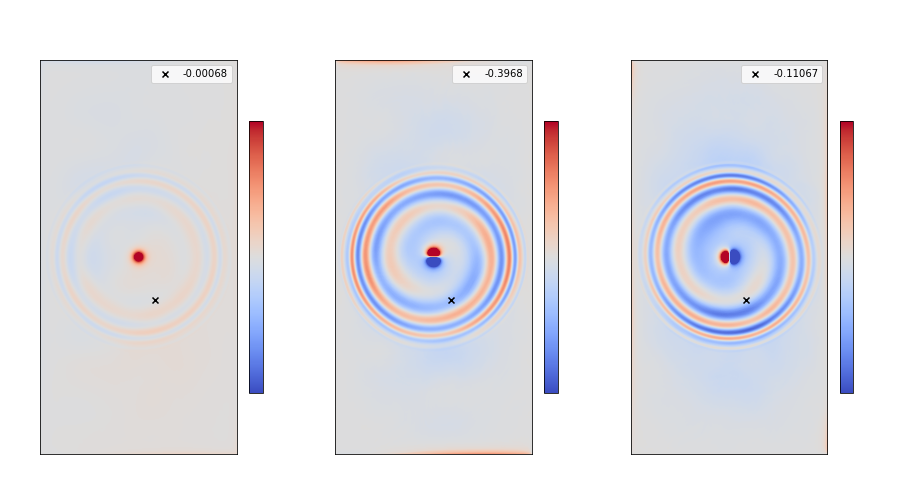

In [62]:
fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)))
axs[0].legend(labelcolor="black")
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)))
axs[1].legend(labelcolor="black")
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)))
axs[2].legend(labelcolor="black")
fig.suptitle("Truth", y=0.85)


### Ensemble

In [17]:
vars = np.load("../scripts/Rossby-vars-2023-01-11T12:51:28.npy")
diff_vars = np.load("../scripts/Rossby-diff_vars-2023-01-11T12:51:28.npy")

In [18]:
# Use the "worst" variable 
vars_hv = vars[:,2]
diff_vars_hv = diff_vars[:,2]

In [19]:
def level_work(l):
    # Cubic work in terms of grid size: 2-space + 1-time
    return (2**(l+1))*(2**l)*(2**l)

In [20]:
allwork = 0
for l_idx, l in enumerate(ls):
    if l_idx == 0: 
        allwork += np.sqrt(vars_hv[l_idx] * level_work(l))
    else:
        allwork += np.sqrt(diff_vars_hv[l_idx] * level_work(l))

optNe_ref = np.zeros(len(ls))
for l_idx, l in enumerate(ls):
    if l_idx == 0: 
        optNe_ref[l_idx] = np.sqrt(vars_hv[l_idx]/((2**l)**2)) * allwork
    else: 
        optNe_ref[l_idx] = np.sqrt(diff_vars_hv[l_idx]/((2**l)**2)) * allwork

In [21]:
tau = 0.05
Nes = np.int32(np.ceil(1/(tau**2)*optNe_ref))
Nes

array([1200,   84,   16,    6,    3], dtype=int32)

In [22]:
Nes = [100, 75, 50, 25, 10]

In [23]:
ensemble = []

lvl_ensemble = []
data_args = initLevel(ls[0])
for e in range(Nes[0]):
    wind = wind_sample(KLSampler, wind_weight=wind_weight)
    lvl_ensemble.append(CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind))

ensemble.append(lvl_ensemble)
    

for l_idx in range(1,len(Nes)):
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    data_args0 = initLevel(ls[l_idx])
    data_args1 = initLevel(ls[l_idx-1])
    
    for e in range(Nes[l_idx]):
        wind = wind_sample(KLSampler, wind_weight=wind_weight)
        
        lvl_ensemble0.append(CDKLM16.CDKLM16(gpu_ctx, **data_args0, wind=wind))
        lvl_ensemble1.append(CDKLM16.CDKLM16(gpu_ctx, **data_args1, wind=wind))
    
    ensemble.append([lvl_ensemble0,lvl_ensemble1])

In [24]:
for e in range(Nes[0]):
    ensemble[0][e].step(250000)
    
for l_idx in range(1,len(Nes)):
    for e in range(Nes[l_idx]):
        ensemble[l_idx][0][e].step(250000)
        ensemble[l_idx][1][e].step(250000)

In [63]:
state = []

lvl_state = []
for e in range(Nes[0]):
    eta, hu, hv = ensemble[0][e].download(interior_domain_only=True)
    lvl_state.append(np.array([eta, hu, hv]))
state.append(np.array(lvl_state))
state[0] = np.moveaxis(state[0], 0, -1)

for l_idx in range(1,len(Nes)):
    lvl_state0 = []
    lvl_state1 = []
    for e in range(Nes[l_idx]):
        eta0, hu0, hv0 = ensemble[l_idx][0][e].download(interior_domain_only=True)
        eta1, hu1, hv1 = ensemble[l_idx][1][e].download(interior_domain_only=True)
        lvl_state0.append(np.array([eta0, hu0, hv0]))
        lvl_state1.append(np.array([eta1, hu1, hv1]))
    state.append([np.array(lvl_state0), np.array(lvl_state1)])
    state[l_idx][0] = np.moveaxis(state[l_idx][0], 0, -1)
    state[l_idx][1] = np.moveaxis(state[l_idx][1], 0, -1)

In [64]:
def MLmean(state):
    MLest_mean = np.zeros(state[-1][0].shape[:-1])
    MLest_mean += np.average(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_mean += np.average(state[l_idx][0] - state[l_idx][1].repeat(2,1).repeat(2,2), axis=-1).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)

    return MLest_mean

Text(0.5, 0.85, 'ML mean')

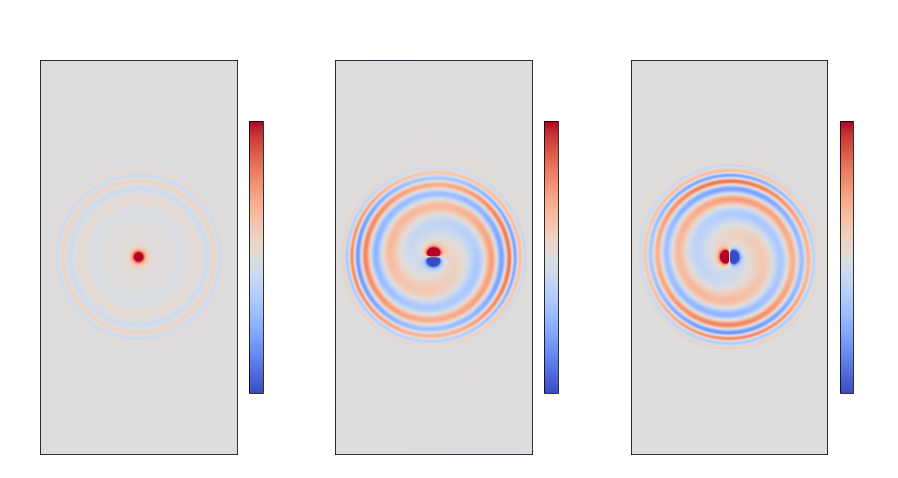

In [65]:
MLest_mean = MLmean(state)
fig, axs = imshow3(MLest_mean)
fig.suptitle("ML mean", y=0.85)

### Kalman gain

In [66]:
perts = []
for l_idx in range(len(ls)):
    perts.append(np.random.multivariate_normal(np.zeros(3), np.diag(R), size=Nes[l_idx]))

In [67]:
Xs = np.linspace(0, ensemble[-1][0][0].nx * ensemble[-1][0][0].dx, ensemble[-1][0][0].nx)
Ys = np.linspace(0, ensemble[-1][0][0].ny * ensemble[-1][0][0].dy, ensemble[-1][0][0].ny)
X, Y = np.meshgrid(Xs, Ys)

obs_loc = np.zeros(2)
obs_loc[0] = X[0,Hx]
obs_loc[1] = Y[Hy,0]
dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

r = 1e7

GC = np.zeros_like(dists)
for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        dist = dists[i,j]
        if dist/r < 1: 
            GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
        elif dist/r >= 1 and dist/r < 2:
            GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))

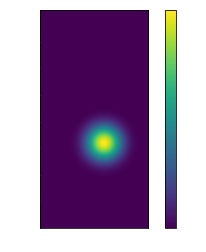

In [68]:
plt.imshow(GC, origin="lower")
plt.colorbar()

In [69]:
from skimage.measure import block_reduce

In [70]:
ML_XY = np.zeros((np.prod(state[-1][0].shape[:-1]),3))

In [71]:
lvl_Xs = np.linspace(0, ensemble[0][0].nx * ensemble[0][0].dx, ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ensemble[0][0].ny * ensemble[0][0].dy, ensemble[0][0].ny)
lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), state[0][0].shape[:-1])

X0 = state[0]
X0mean = np.average(X0, axis=-1)

Y0 = state[0][:,obs_idxs[0],obs_idxs[1]] + perts[0].T
Y0mean = np.average(Y0, axis=-1)

lvl_weight = np.ones(np.prod(X0mean.shape))

ML_XY += (lvl_weight[:,np.newaxis]*1/Nes[0]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2).reshape(-1,ML_XY.shape[-1])

In [72]:
for l_idx in range(1,len(ls)):
    l = ls[l_idx]

    lvl_Xs0 = np.linspace(0, ensemble[l_idx][0][0].nx * ensemble[l_idx][0][0].dx, ensemble[l_idx][0][0].nx)
    lvl_Ys0 = np.linspace(0, ensemble[l_idx][0][0].ny * ensemble[l_idx][0][0].dy, ensemble[l_idx][0][0].ny)
    lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
    obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), state[l_idx][0][0].shape[:-1])

    lvl_Xs1 = np.linspace(0, ensemble[l_idx][1][0].nx * ensemble[l_idx][1][0].dx, ensemble[l_idx][1][0].nx)
    lvl_Ys1 = np.linspace(0, ensemble[l_idx][1][0].ny * ensemble[l_idx][1][0].dy, ensemble[l_idx][1][0].ny)
    lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
    obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), state[l_idx][1][0].shape[:-1])

    X0 = state[l_idx][0]
    X0mean = np.average(X0, axis=-1)
    X1 = state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = np.average(X1, axis=-1)

    Y0 = state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] + perts[l_idx].T
    Y0mean = np.average(Y0, axis=-1)
    Y1 = state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] + perts[l_idx].T
    Y1mean = np.average(Y1, axis=-1)

    lvl_weight = np.tile(block_reduce(GC, block_size=(2**(ls[-1]-l),2**(ls[-1]-l)), func=np.mean).flatten(),3)

    ML_XY += (lvl_weight[:,np.newaxis] * ( 1/Nes[l_idx]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T) - 1/Nes[l_idx]*((X1-X1mean[:,:,:,np.newaxis]).reshape(-1,X1.shape[-1]) @ (Y1 - Y1mean[:,np.newaxis]).T) )).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2).reshape(-1,ML_XY.shape[-1])


In [73]:
ML_HXY = ML_XY.reshape(state[-1][0].shape[:-1] + (3,))[:,obs_idxs0[0],obs_idxs0[1],:]
ML_YY  = ML_HXY + np.diag(R)

ML_K = ML_XY @ np.linalg.inv(ML_YY)

Text(0.5, 0.9, 'Kalman Gain')

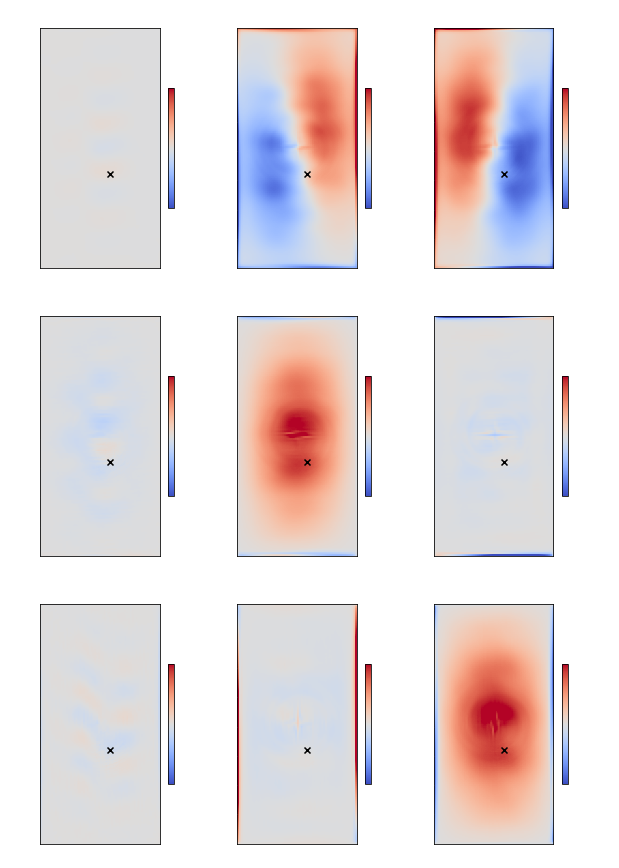

In [74]:
ML_K_field = ML_K.reshape(state[-1][0].shape[:-1] + (3,))

vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(ML_K_field[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

### Update

In [75]:
lvl_Xs = np.linspace(0, ensemble[0][0].nx * ensemble[0][0].dx, ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ensemble[0][0].ny * ensemble[0][0].dy, ensemble[0][0].ny)
lvl_X, lvl_Y = np.meshgrid(lvl_Xs, lvl_Ys)

obs_idxs = np.unravel_index(np.argmin((lvl_X - X[0,Hx])**2 + (lvl_Y - Y[Hy,0])**2), state[0][0].shape[:-1])

state[0] = state[0] + block_reduce((ML_K @ (obs[:,np.newaxis] - state[0][:,obs_idxs[0],obs_idxs[1]] - perts[0].T)).reshape(state[-1][0].shape[:-1] + (Nes[0],)), block_size=(1,2**(ls[-1]-ls[0]), 2**(ls[-1]-ls[0]), 1), func=np.mean)

for l_idx in range(1,len(ls)):
    l = ls[l_idx]

    lvl_Xs0 = np.linspace(0, ensemble[l_idx][0][0].nx * ensemble[l_idx][0][0].dx, ensemble[l_idx][0][0].nx)
    lvl_Ys0 = np.linspace(0, ensemble[l_idx][0][0].ny * ensemble[l_idx][0][0].dy, ensemble[l_idx][0][0].ny)
    lvl_X0, lvl_Y0 = np.meshgrid(lvl_Xs0, lvl_Ys0)
    obs_idxs0 = np.unravel_index(np.argmin((lvl_X0 - X[0,Hx])**2 + (lvl_Y0 - Y[Hy,0])**2), state[l_idx][0][0].shape[:-1])

    lvl_Xs1 = np.linspace(0, ensemble[l_idx][1][0].nx * ensemble[l_idx][1][0].dx, ensemble[l_idx][1][0].nx)
    lvl_Ys1 = np.linspace(0, ensemble[l_idx][1][0].ny * ensemble[l_idx][1][0].dy, ensemble[l_idx][1][0].ny)
    lvl_X1, lvl_Y1 = np.meshgrid(lvl_Xs1, lvl_Ys1)
    obs_idxs1 = np.unravel_index(np.argmin((lvl_X1 - X[0,Hx])**2 + (lvl_Y1 - Y[Hy,0])**2), state[l_idx][1][0].shape[:-1])

    state[l_idx][0] = state[l_idx][0] + block_reduce((ML_K @ (obs[:,np.newaxis] - state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] - perts[l_idx].T)).reshape(state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l), 2**(ls[-1]-l), 1), func=np.mean)
    state[l_idx][1] = state[l_idx][1] + block_reduce((ML_K @ (obs[:,np.newaxis] - state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] - perts[l_idx].T)).reshape(state[-1][0].shape[:-1]+(Nes[l_idx],)), block_size=(1,2**(ls[-1]-l+1), 2**(ls[-1]-l+1), 1), func=np.mean)

Text(0.5, 0.9, 'Posterior ML mean')

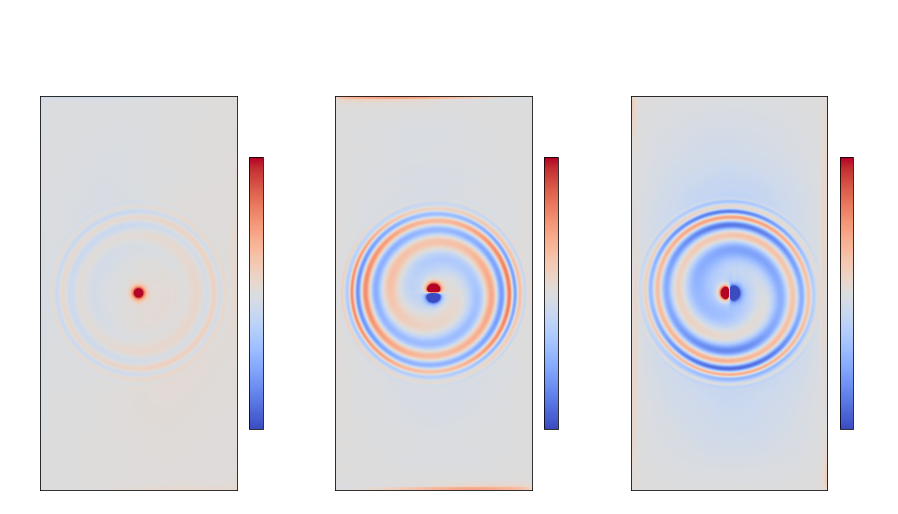

In [76]:
MLest_mean = MLmean(state)
fig, axs = imshow3(MLest_mean)
fig.suptitle("Posterior ML mean", y=0.9)